<h1 style='text-align: center;'>MODELING (HYPERPARAMETER TUNING)</h1>

### Import the Libraries

In [22]:
import warnings
warnings.filterwarnings("ignore")

from joblib import load

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as pyo
pyo.init_notebook_mode()

import numpy as np

import optuna

from sklearn.metrics import f1_score

from pprint import pprint
import os

### Load the Data

In [21]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/serialized-uti-data/preprocessed_unscaled_data.joblib
/kaggle/input/serialized-uti-data/preprocessed_data.joblib


In [23]:
X_train_scaled, _, y_train, _ = load(r"/kaggle/input/serialized-uti-data/preprocessed_data.joblib")

In [24]:
X_train_scaled

Age     Color  Transparency  Glucose  Protein        pH  \
0     0.305897  0.444444          0.50      0.0     0.00  0.333333   
1     0.410768  0.000000          0.00      0.0     0.00  0.342446   
2     0.842520  0.000000          0.00      0.0     0.00  0.390418   
3     0.925286  0.555556          0.25      0.0     0.00  0.000000   
4     0.651294  0.000000          0.00      0.0     0.00  0.333333   
...        ...       ...           ...      ...      ...       ...   
1945  0.403825  0.555556          0.25      0.0     0.00  0.000000   
1946  0.573683  0.111111          0.25      0.0     0.25  0.333333   
1947  0.699133  0.333333          0.50      0.0     0.50  0.375206   
1948  0.527559  0.555556          0.00      0.0     0.00  0.333333   
1949  0.223847  0.444444          0.00      0.0     0.50  0.333333   

      Specific_Gravity       WBC   RBC  Epithelial_Cells  Mucous_Threads  \
0             0.570580  0.916667  0.00          0.666667        0.166667   
1             0.000000  0.916667  0.00          0.166667        0.333333   
2             0.643833  0.416667  0.00          0.666667        0.500000   
3             0.400000  0.666667  0.00          0.333333        0.166667   
4             0.400000  0.916667  0.00          0.333333        0.000000   
...                ...       ...   ...               ...             ...   
1945          1.000000  0.000000  0.00          0.666667        0.666667   
1946          0.340027  0.750000  0.25          0.166667        0.000000   
1947          0.700165  0.416667  0.00          0.666667        0.333333   
1948          0.600000  0.000000  0.00          0.166667        0.333333   
1949          1.000000  0.250000  0.00          0.166667        1.000000   

      Amorphous_Urates  Bacteria   MALE  FEMALE  
0             0.000000       0.6  False    True  
1             0.000000       0.8  False    True  
2             0.000000       0.6  False    True  
3             0.000000       0.6  False    True  
4             0.000000       0.2  False    True  
...                ...       ...    ...     ...  
1945          0.000000       0.6  False    True  
1946          0.000000       0.6  False    True  
1947          0.166667       1.0  False    True  
1948          0.000000       0.0   True   False  
1949          0.000000       0.6   True   False  

[1950 rows x 15 columns]

In [25]:
y_train

2746    1
1992    1
1545    1
1914    1
449     0
       ..
378     0
2645    1
2369    1
1197    0
456     0
Name: Diagnosis, Length: 1950, dtype: int64

In [26]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train_scaled, 
                                                                    y_train, 
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                   stratify = y_train)

### Hyperparameter Tuning

In [27]:
def show_study_summary(study):
    """
    Display a summary of the optimization study.

    Parameters
    ----------
    study : optuna.study.Study
        The optimization study to summarize.

    Returns
    -------
    None
        This function does not return any values. It displays information and plots.
    """
    print("\033[1mBest Hyperparameters")
    pprint(study.best_params)
    print()

    print("\033[1mAccuracy for the Best Hyperparameters")
    print(study.best_value)

    optimization_history_plot = optuna.visualization.plot_optimization_history(study)
    param_importances_plot = optuna.visualization.plot_param_importances(study)
    parallel_coordinate_plot = optuna.visualization.plot_parallel_coordinate(study)

    optimization_history_plot.update_layout({"height": 600})
    param_importances_plot.update_layout({"height": 600})
    parallel_coordinate_plot.update_layout({"height": 600})

    optimization_history_plot.show()
    param_importances_plot.show()
    parallel_coordinate_plot.show()

### Logistic Regression

In [28]:
def logreg_objective(trial):
    """
    Objective function for optimizing logistic regression hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    logreg = LogisticRegression(**params, max_iter=2000)

    logreg.fit(X_train_val, y_train_val)

    threshold = trial.suggest_float('threshold', 0.1, 1)

    yhat = [1 if proba[1] > threshold else 0 for proba in logreg.predict_proba(X_test_val)]

    f1_score_ = f1_score(y_test_val, yhat)

    return f1_score_

log_reg_study = optuna.create_study(direction="maximize", study_name="logreg_tuning")

log_reg_study.optimize(logreg_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-05 12:02:54,639] A new study created in memory with name: logreg_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-05 12:02:54,748] Trial 0 finished with value: 0.9307875894988067 and parameters: {'tol': 9.12121121578802e-06, 'C': 0.2417998660721489, 'threshold': 0.3462665840829138}. Best is trial 0 with value: 0.9307875894988067.
[I 2023-11-05 12:02:54,782] Trial 1 finished with value: 0.9263657957244656 and parameters: {'tol': 0.006383549186631276, 'C': 0.2874532087583858, 'threshold': 0.2766425017814288}. Best is trial 0 with value: 0.9307875894988067.
[I 2023-11-05 12:02:54,836] Trial 3 finished with value: 0.9285714285714286 and parameters: {'tol': 1.1757592009139122e-06, 'C': 0.17321799411108818, 'threshold': 0.33795059404817346}. Best is trial 0 with value: 0.9307875894988067.
[I 2023-11-05 12:02:54,855] Trial 2 finished with value: 0.830860534124629 and parameters: {'tol': 0.000599270052437578, 'C': 0.5767169665981831, 'threshold': 0.8811856902971112}. Best is trial 0 with value: 0.9307875894988067.
[I 2023-11-05 12:02:54,905] Trial 5 finished with value: 0.9457364341085271 and p

Best Hyperparameters
{'C': 0.9582269430751578,
 'threshold': 0.6145219845588178,
 'tol': 8.839318645177164e-05}

Accuracy for the Best Hyperparameters
0.9625935162094763


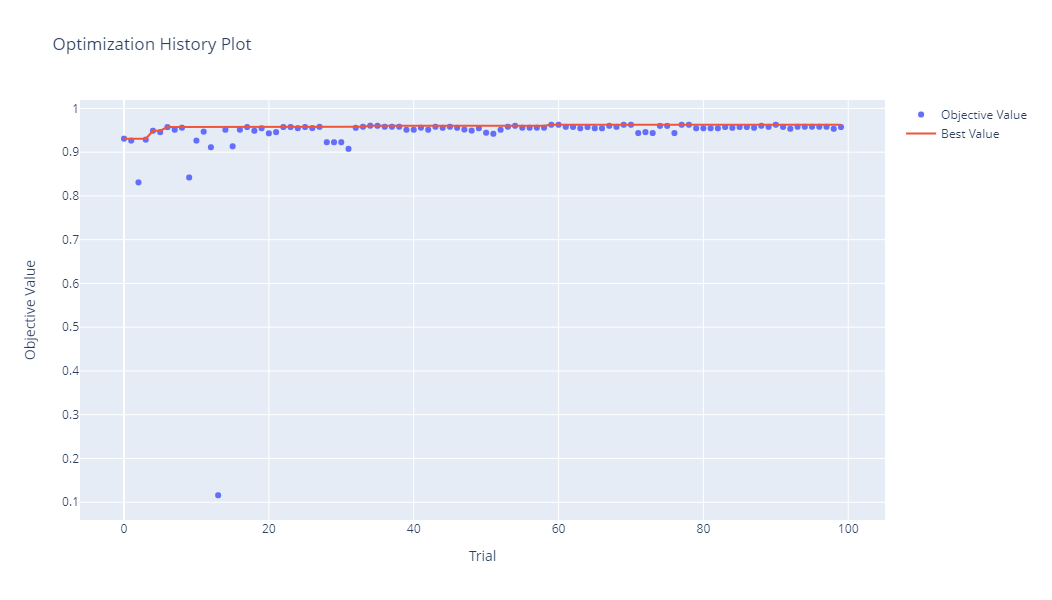

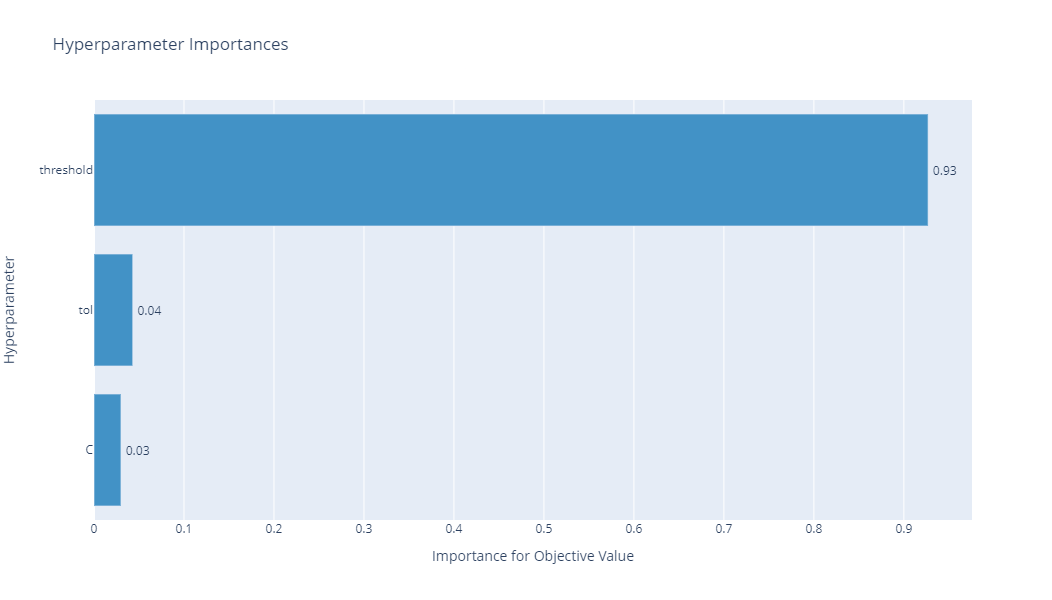

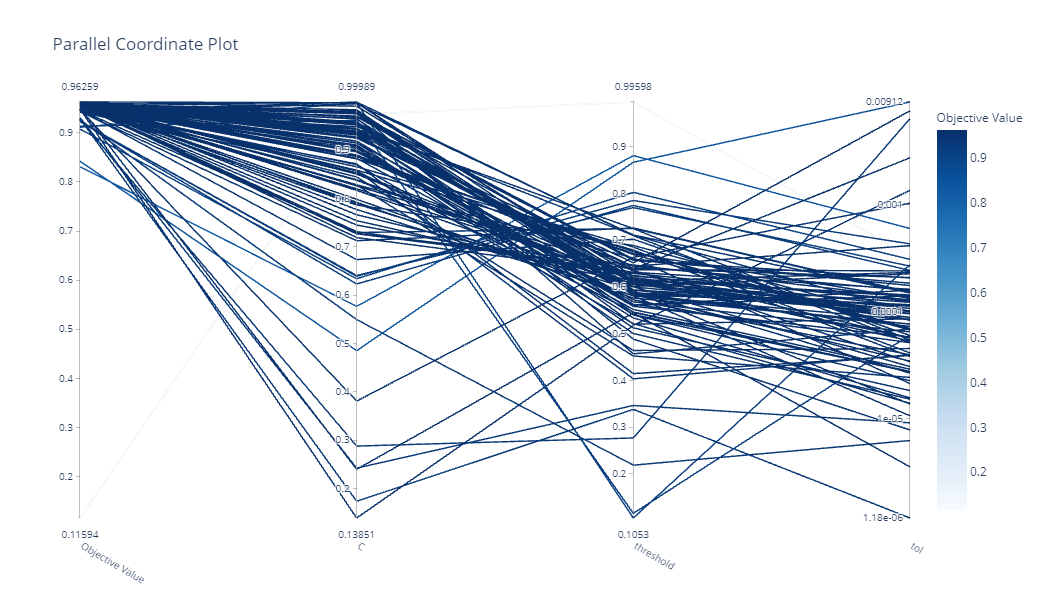

In [29]:
show_study_summary(log_reg_study)

### Random Forest

In [30]:
def forest_objective(trial):
    """
    Objective function for optimizing random forest hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 20, 150),
        "max_depth": trial.suggest_int('max_depth', 10, 30),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None, 2]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    }

    random_forest = RandomForestClassifier(**params)

    random_forest.fit(X_train_val, y_train_val)

    yhat = random_forest.predict(X_test_val)

    f1_score_ = f1_score(y_test_val, yhat)

    return f1_score_

forest_study = optuna.create_study(direction="maximize", study_name="forest_tuning")

forest_study.optimize(forest_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-05 12:03:04,781] A new study created in memory with name: forest_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-05 12:03:05,483] Trial 3 finished with value: 0.9748743718592966 and parameters: {'n_estimators': 27, 'max_depth': 11, 'max_features': None, 'criterion': 'entropy'}. Best is trial 3 with value: 0.9748743718592966.
[I 2023-11-05 12:03:05,992] Trial 1 finished with value: 0.9798994974874372 and parameters: {'n_estimators': 76, 'max_depth': 28, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.9798994974874372.
[I 2023-11-05 12:03:06,119] Trial 0 finished with value: 0.9798994974874372 and parameters: {'n_estimators': 75, 'max_depth': 15, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 1 with value: 0.9798994974874372.
[I 2023-11-05 12:03:06,279] Trial 2 finished with value: 0.9798994974874372 and parameters: {'n_estimators': 102, 'max_depth': 26, 'max_features': 2, 'criterion': 'gini'}. Best is trial 1 with value: 0.9798994974874372.
[I 2023-11-05 12:03:06,427] Trial 4 finished with value: 0.9774436090225563 and parameters: {'n_estimato

Best Hyperparameters
{'criterion': 'entropy',
 'max_depth': 17,
 'max_features': 'log2',
 'n_estimators': 79}

Accuracy for the Best Hyperparameters
0.9848484848484849


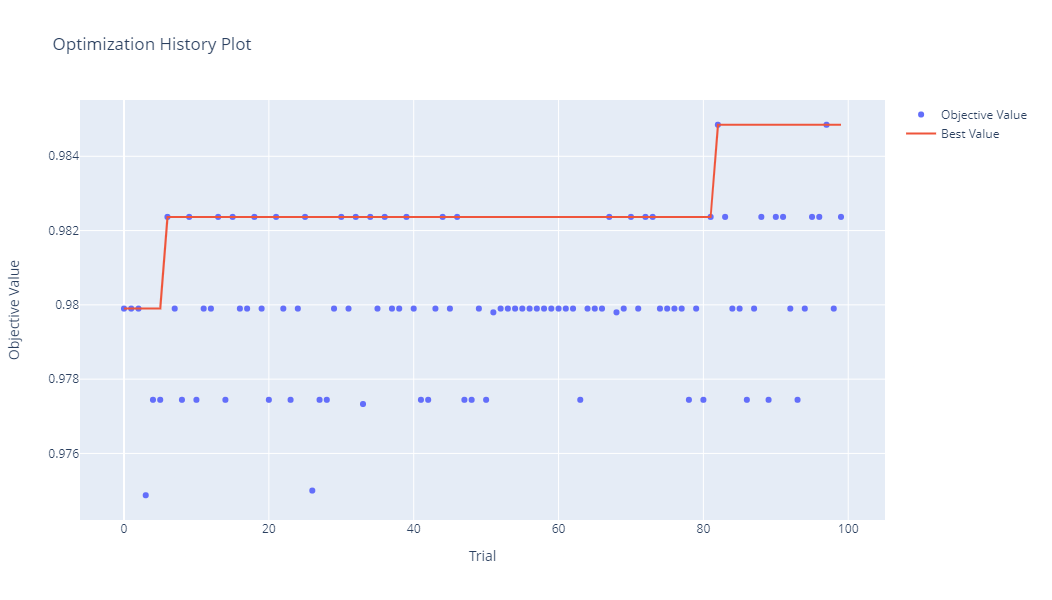

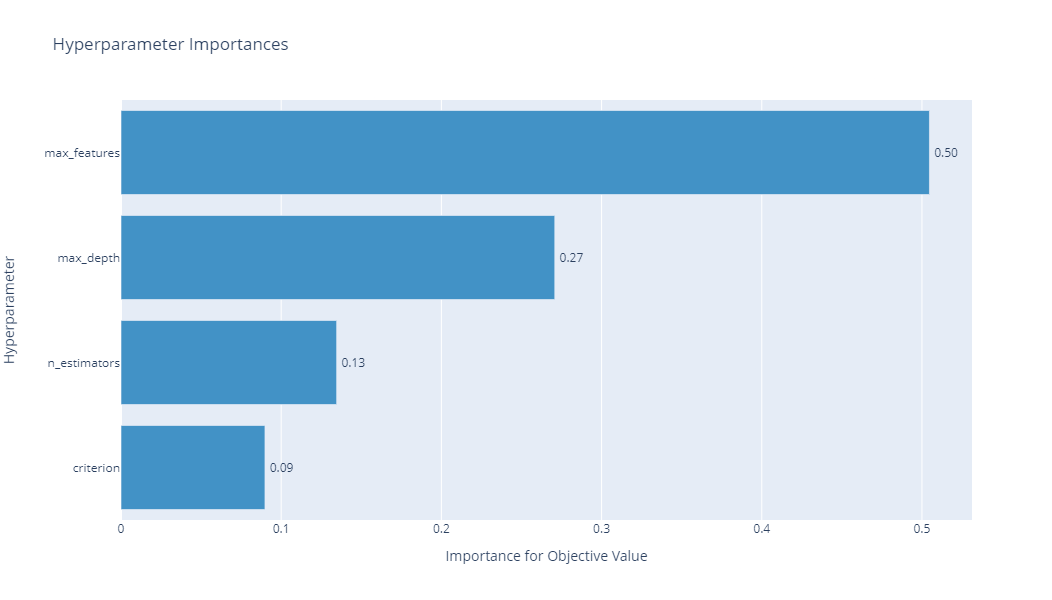

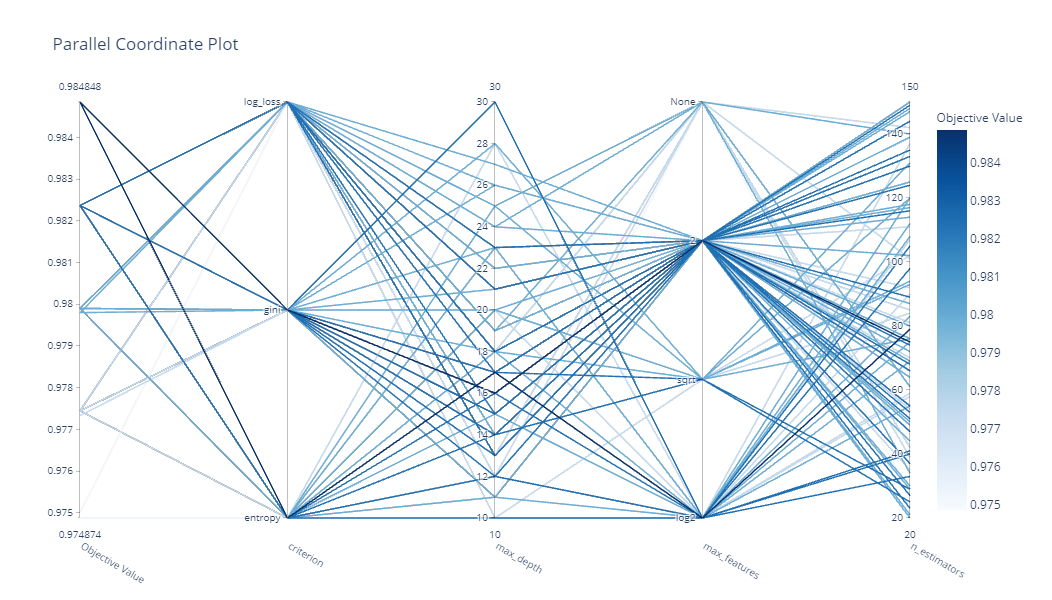

In [31]:
show_study_summary(forest_study)

### Support Vector Machine


In [32]:
def SVC_objective(trial):
    """
    Objective function for optimizing Support Vector Machine (SVM) hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        "C": trial.suggest_float("C", 0.1, 1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL = SVC(**params)

    SVC_MODEL.fit(X_train_val, y_train_val)

    yhat = SVC_MODEL.predict(X_test_val)

    f1_score_ = f1_score(y_test_val, yhat)

    return f1_score_

SVM_SVC_study = optuna.create_study(direction="maximize", study_name="SVM_tuning")

SVM_SVC_study.optimize(SVC_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-05 12:03:41,369] A new study created in memory with name: SVM_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-05 12:03:41,502] Trial 1 finished with value: 0.9653465346534654 and parameters: {'C': 0.2120591841194342, 'kernel': 'rbf'}. Best is trial 1 with value: 0.9653465346534654.
[I 2023-11-05 12:03:41,522] Trial 2 finished with value: 0.9653465346534654 and parameters: {'C': 0.19506150255548615, 'kernel': 'rbf'}. Best is trial 1 with value: 0.9653465346534654.
[I 2023-11-05 12:03:41,569] Trial 4 finished with value: 0.982367758186398 and parameters: {'C': 0.6318539312267191, 'kernel': 'poly'}. Best is trial 4 with value: 0.982367758186398.
[I 2023-11-05 12:03:41,605] Trial 3 finished with value: 0.6033254156769596 and parameters: {'C': 0.5998705982624667, 'kernel': 'sigmoid'}. Best is trial 4 with value: 0.982367758186398.
[I 2023-11-05 12:03:41,619] Trial 5 finished with value: 0.9466019417475728 and parameters: {'C': 0.28745224750559933, 'kernel': 'linear'}. Best is trial 4 with value: 0.982367758186398.
[I 2023-11-05 12:03:41,640] Trial 0 finished with value: 0.648648648648648

Best Hyperparameters
{'C': 0.6318539312267191, 'kernel': 'poly'}

Accuracy for the Best Hyperparameters
0.982367758186398


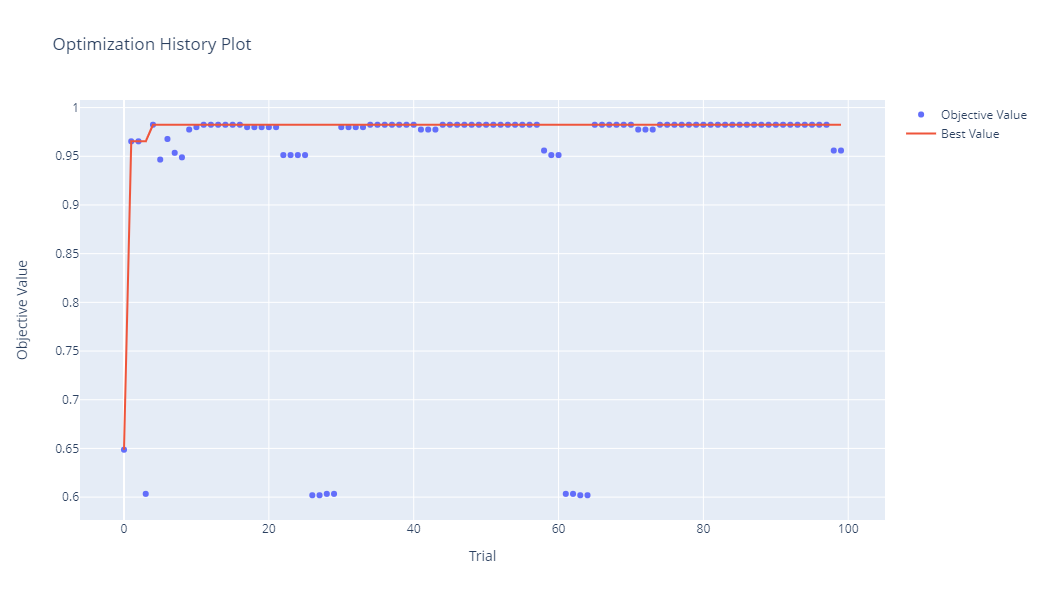

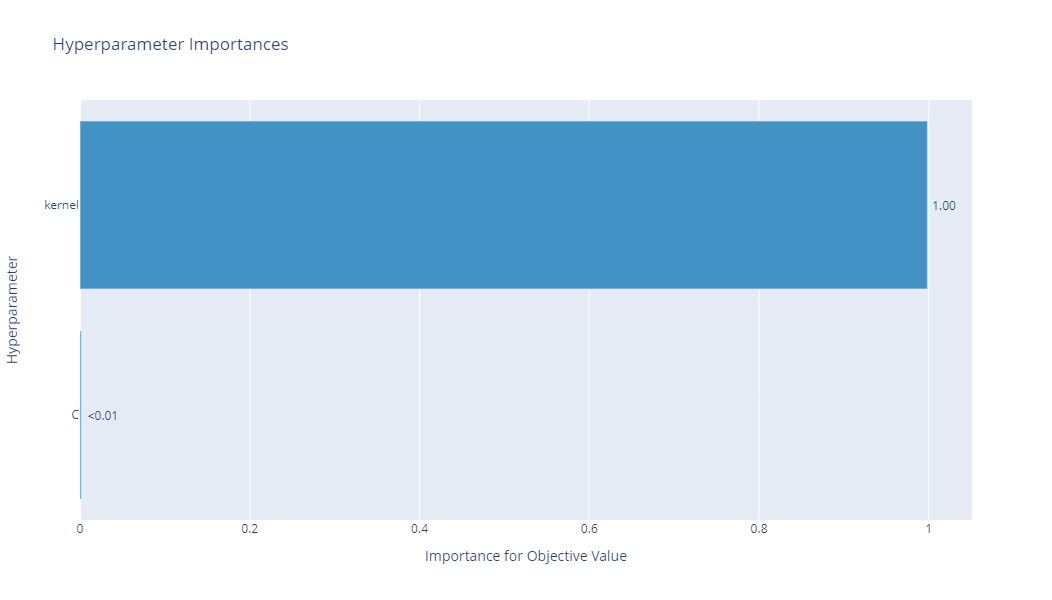

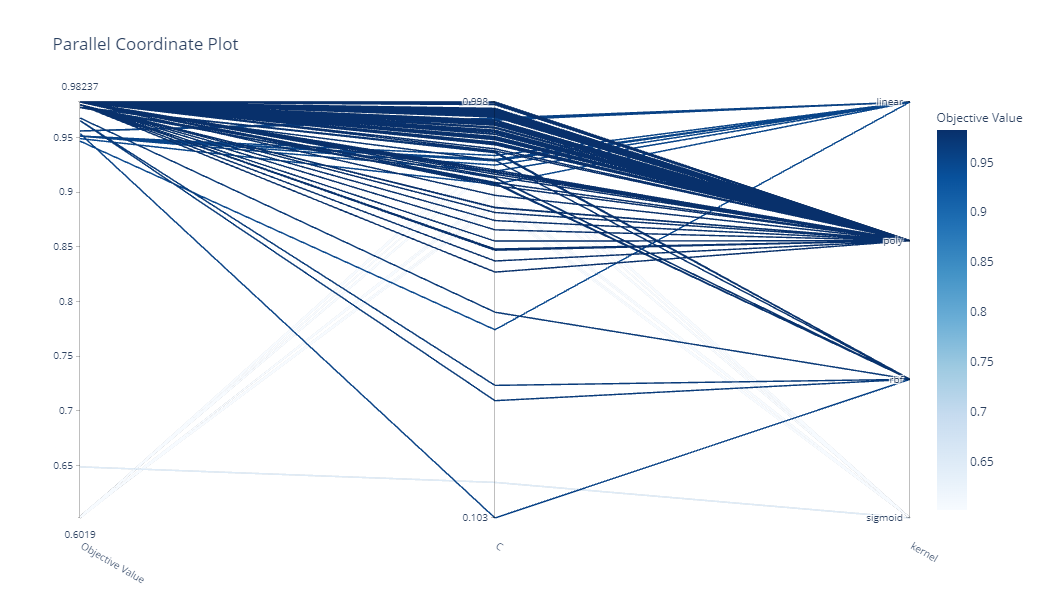

In [33]:
show_study_summary(SVM_SVC_study)

### XGBoost

In [34]:
def XGB_objective(trial):
    """
    Objective function for optimizing XGBoost hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    }

    XGB_model = xgb.XGBClassifier(**params)

    XGB_model.fit(X_train_val, y_train_val)

    yhat = XGB_model.predict(X_test_val)

    f1_score_ = f1_score(y_test_val, yhat)

    return f1_score_

XGB_study = optuna.create_study(direction="maximize", study_name="XGB_tuning")

XGB_study.optimize(XGB_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-05 12:03:45,570] A new study created in memory with name: XGB_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-05 12:03:47,571] Trial 0 finished with value: 0.9798994974874372 and parameters: {'reg_alpha': 0.20519923426337724, 'n_estimators': 250, 'max_depth': 14, 'learning_rate': 0.007145587828651048}. Best is trial 0 with value: 0.9798994974874372.
[I 2023-11-05 12:03:47,845] Trial 2 finished with value: 0.9774436090225563 and parameters: {'reg_alpha': 0.6175922721993716, 'n_estimators': 650, 'max_depth': 3, 'learning_rate': 0.0033231394077298947}. Best is trial 0 with value: 0.9798994974874372.
[I 2023-11-05 12:03:47,919] Trial 3 finished with value: 0.9774436090225563 and parameters: {'reg_alpha': 0.5807446148505359, 'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.00790952276245604}. Best is trial 0 with value: 0.9798994974874372.
[I 2023-11-05 12:03:48,301] Trial 1 finished with value: 0.9798994974874372 and parameters: {'reg_alpha': 0.6920648349755766, 'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.003652384881137691}. Best is trial 0 with value: 0.97989949748

Best Hyperparameters
{'learning_rate': 0.007145587828651048,
 'max_depth': 14,
 'n_estimators': 250,
 'reg_alpha': 0.20519923426337724}

Accuracy for the Best Hyperparameters
0.9798994974874372


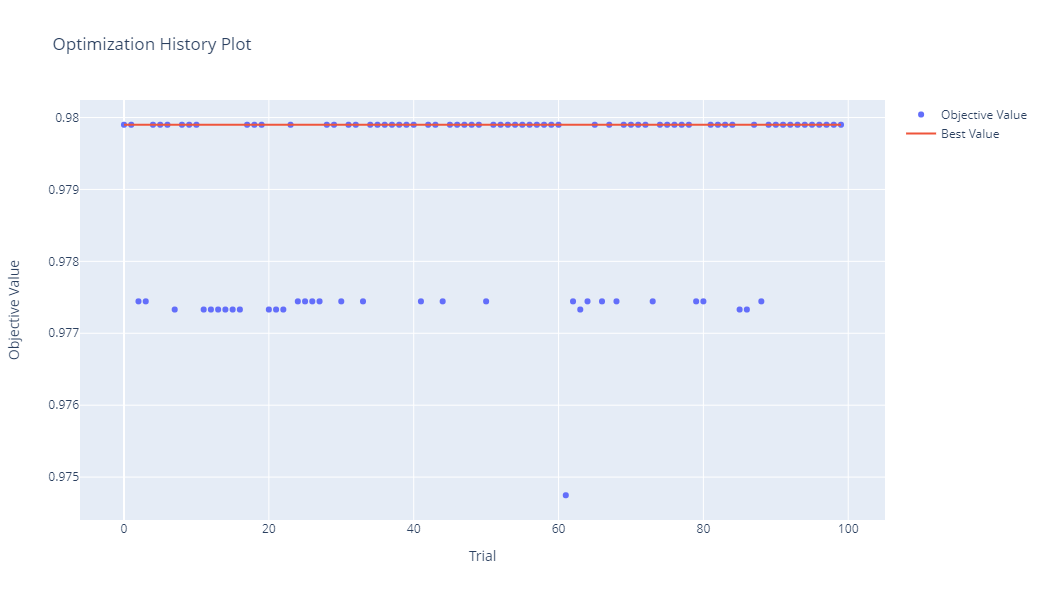

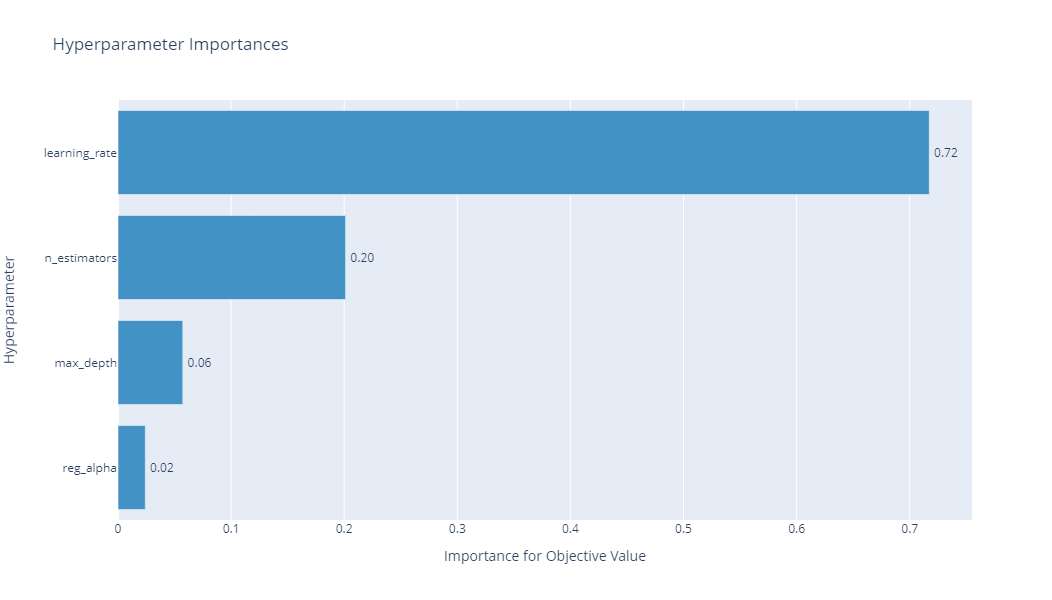

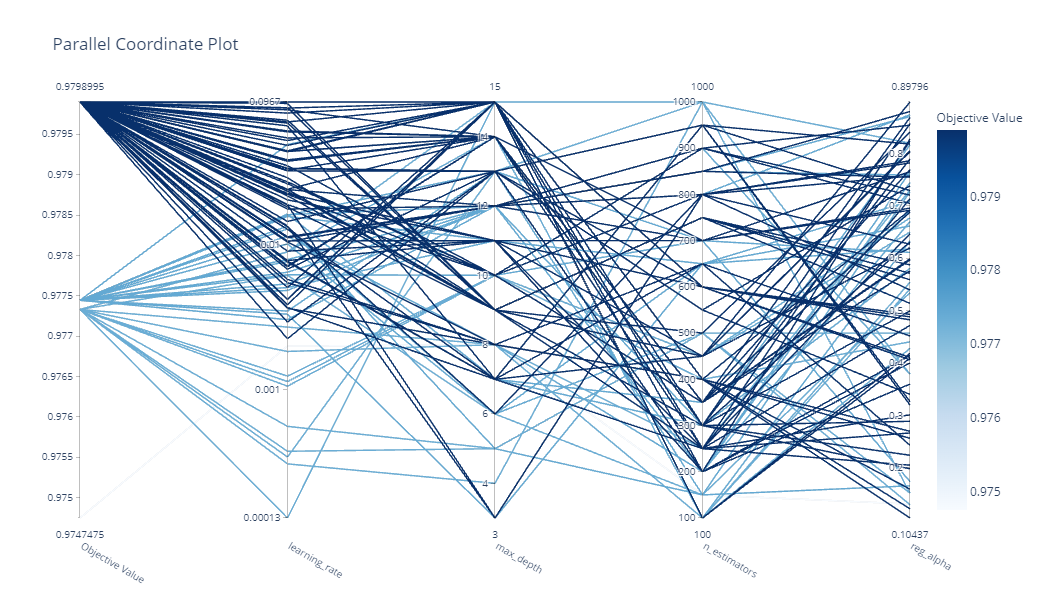

In [35]:
show_study_summary(XGB_study)

### Light GBM

In [36]:
def lightgmb_objective(trial):
    """
    Objective function for optimizing LightGBM hyperparameters.

    Parameters
    ----------
    trial : optuna.Trial
        A single optimization trial.

    Returns
    -------
    float
        F1 score obtained using the specified hyperparameters.
    """
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        'learning_rate': trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9)
    }
    
    lgbm_model = lgb.LGBMClassifier(**params)
    
    lgbm_model.fit(X_train_val, y_train_val) 
    
    yhat = lgbm_model.predict(X_test_val)
    
    f1_score_ = f1_score(y_test_val, yhat)
    
    return f1_score_

lgbm_study = optuna.create_study(direction="maximize", study_name="lgbm_tuning")

lgbm_study.optimize(lightgmb_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-11-05 12:05:06,905] A new study created in memory with name: lgbm_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-05 12:05:07,702] Trial 3 finished with value: 0.9798994974874372 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.08607682077424328, 'reg_alpha': 0.6919950768096387}. Best is trial 3 with value: 0.9798994974874372.
[I 2023-11-05 12:05:08,421] Trial 2 finished with value: 0.9748743718592966 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0004743719787135094, 'reg_alpha': 0.4291651381585121}. Best is trial 3 with value: 0.9798994974874372.
[I 2023-11-05 12:05:08,723] Trial 0 finished with value: 0.972568578553616 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'n_estimators': 250, 'max_depth': -1, 'learning_rate': 0.002078700647562507, 'reg_alpha': 0.7542814488319617}. Best is trial 3 with value: 0.9798994974874372.
[I 2023-11-05 12:05:09,013] Trial 4 finished with value: 0.9748743718592966 and parameters: {'boosting_type': 'goss',

Best Hyperparameters
{'boosting_type': 'gbdt',
 'learning_rate': 0.08607682077424328,
 'max_depth': 5,
 'n_estimators': 150,
 'num_leaves': 180,
 'reg_alpha': 0.6919950768096387}

Accuracy for the Best Hyperparameters
0.9798994974874372


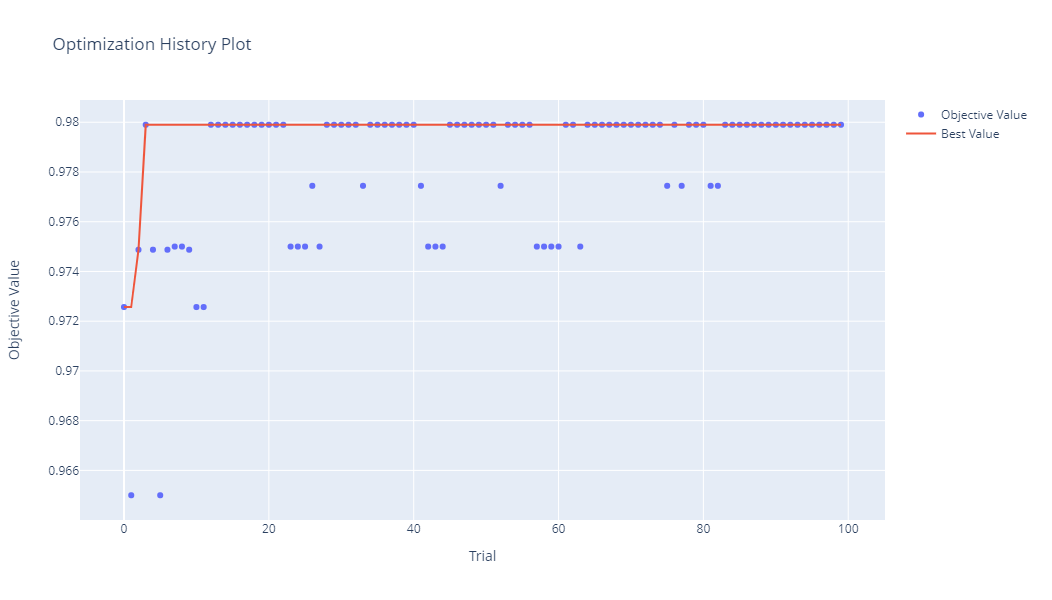

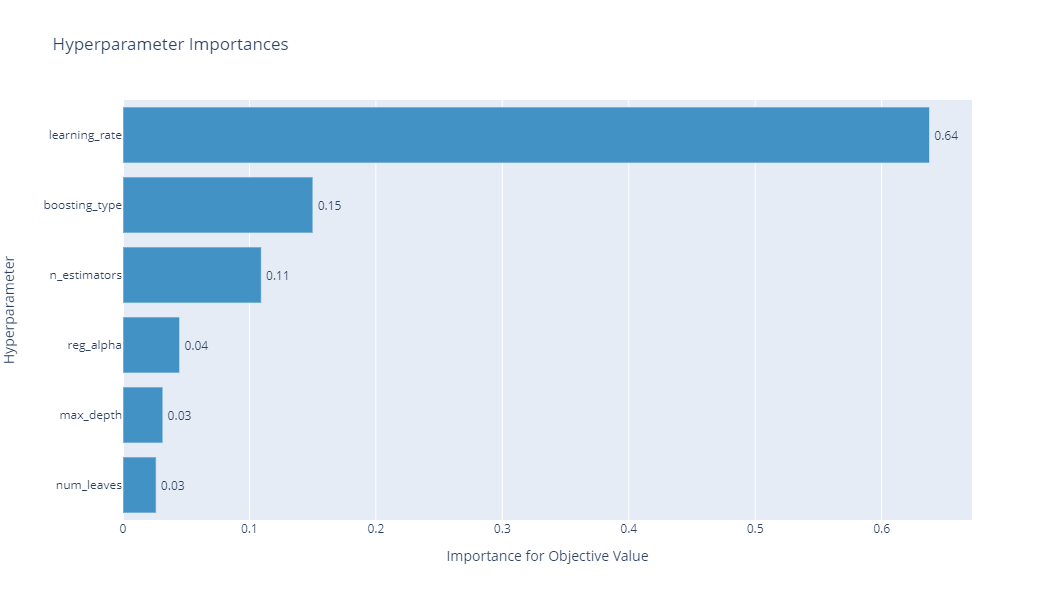

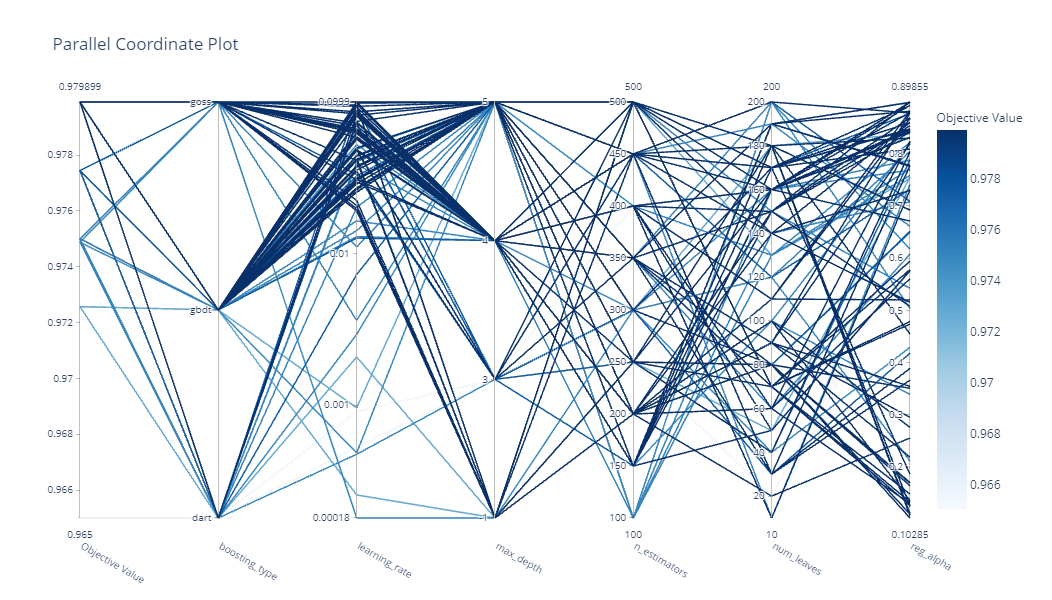

In [37]:
show_study_summary(lgbm_study)

### ANN: Multi-layer Perceptron

#### Load the data using Pytorch

In [38]:
class UTIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = self.df.iloc[idx, :][:-1].values.astype("float32").reshape((self.df.columns.__len__()-1, 1))
        y = self.df.iloc[idx, :][-1:].values.astype("long").reshape((1, 1))
        
        if transform:
            x = transform(x)
            y = transform(y)
            
        return (x, y)

#### Transformation

In [39]:
transform = transforms.ToTensor()

X_train_scaled_reset = X_train_scaled.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

df = pd.concat([X_train_scaled_reset, y_train_reset], axis=1)

data = UTIDataset(df, transform)

#### Split the data

In [41]:
train_set_torch, val_set_torch, test_set_torch = torch.utils.data.random_split(data, [0.6, 0.2, 0.2])

In [42]:
torch.manual_seed(42)
np.random.seed(42)

batch_size = 15

train_loader = DataLoader(train_set_torch, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_set_torch, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set_torch, batch_size=batch_size, shuffle=False)

#### MLP Architecture

![Alt text](figures/MLP_ARCHITECTURE.jpg)

In [43]:
class ClassifierNN(nn.Module):
    def __init__(self, activation_function):
        super().__init__()
        
        self.activation_function = activation_function
        
        self.fcn1 = nn.Linear(15, 32)
        self.fcn2 = nn.Linear(32, 64)
        self.fcn3 = nn.Linear(64, 128)
        self.fcn4 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = x.view(-1, 15)
        
        x = self.activation_function(self.fcn1(x))
        x = self.activation_function(self.fcn2(x))
        x = self.activation_function(self.fcn3(x))
        
        x = self.fcn4(x)
        
        return x

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#### MLP TUNING

In [45]:
def tune_NN(trial, train_loader_, val_loader_):
    """
      Tune a Convolutional Neural Network (CNN) using various hyperparameters.

      Parameters
      ----------
      trial : optuna.Trial
          An Optuna trial object used for hyperparameter optimization.

      train_loader_ : torch.utils.data.DataLoader
          DataLoader for the training dataset.

      val_loader_ : torch.utils.data.DataLoader
          DataLoader for the validation dataset.

      Returns
      -------
      float
          The accuracy of the tuned CNN model on the validation dataset.

      Notes
      -----
      This function performs hyperparameter optimization for a CNN model using the Optuna library.

      The hyperparameters that can be optimized are:
      - Kernel size for convolutional layers
      - Choice of optimizer (SGD, Adam, or RMSprop)
      - Activation functions (ReLU, Leaky ReLU, or Tanh)
      - Learning rate
      - Number of training epochs

      The CNN model is trained and tuned using the specified hyperparameters, and its accuracy on the
      validation dataset is returned.

      Examples
      --------
      >>> import optuna
      >>> study = optuna.create_study(direction='maximize')
      >>> study.optimize(tune_CNN, n_trials=10, args=(train_loader, val_loader))
      >>> best_trial = study.best_trial
      >>> best_accuracy = best_trial.value
      >>> best_params = best_trial.params
      >>> print(f"Best accuracy: {best_accuracy}")
      >>> print(f"Best hyperparameters: {best_params}")
    """
    global device

    optimizers_ = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
    activation_functions = trial.suggest_categorical("activation function", [F.relu, F.leaky_relu, F.tanh])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    epochs = trial.suggest_int("epochs", 10, 50)

    NN_model = ClassifierNN(activation_functions)

    NN_model = NN_model.to(device)

    criterion = nn.CrossEntropyLoss()

    if optimizers_ == "SGD":
        optimizer = optim.SGD(NN_model.parameters(), lr=learning_rate)
    elif optimizers_ == "Adam":
        optimizer = optim.Adam(NN_model.parameters(), lr=learning_rate)
    elif optimizers_ == "RMSprop":
        optimizer = optim.RMSprop(NN_model.parameters(), lr=learning_rate)

    for _ in range(epochs):
        running_loss = 0.0

        for x_train, y_train in train_loader_:
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            optimizer.zero_grad()
            outputs = NN_model(x_train)
            
            y_train = y_train.flatten()

            loss = criterion(outputs, y_train)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for val_X, val_y in val_loader_:
            val_X = val_X.to(device)
            val_y = val_y.to(device)

            outputs = NN_model(val_X)

            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend([arr.flatten()[0] for arr in val_y.cpu().numpy()])
            predicted_labels.extend(predicted.cpu().numpy())

    f1 = f1_score(true_labels, predicted_labels)

    torch.cuda.empty_cache()

    return f1

In [46]:
mlp_study = optuna.create_study(direction="maximize")

params = {"train_loader_":train_loader,
         "val_loader_":val_loader}

mlp_study.optimize(lambda trial: tune_NN(trial, **params),
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-11-05 12:05:48,369] A new study created in memory with name: no-name-71c54b06-123c-4f55-ac01-c8624235e304


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-05 12:06:36,827] Trial 2 finished with value: 0.9790575916230367 and parameters: {'optimizer': 'RMSprop', 'activation function': <function leaky_relu at 0x7a6f9544bc70>, 'learning_rate': 0.0030870589905720985, 'epochs': 13}. Best is trial 2 with value: 0.9790575916230367.
[I 2023-11-05 12:06:57,098] Trial 1 finished with value: 0.9326683291770573 and parameters: {'optimizer': 'SGD', 'activation function': <function relu at 0x7a6f9544b880>, 'learning_rate': 0.004201297195037913, 'epochs': 29}. Best is trial 2 with value: 0.9790575916230367.
[I 2023-11-05 12:07:11,351] Trial 3 finished with value: 0.9714285714285714 and parameters: {'optimizer': 'Adam', 'activation function': <function relu at 0x7a6f9544b880>, 'learning_rate': 0.00423632799646662, 'epochs': 18}. Best is trial 2 with value: 0.9790575916230367.
[I 2023-11-05 12:07:26,052] Trial 0 finished with value: 0.9587628865979382 and parameters: {'optimizer': 'SGD', 'activation function': <function leaky_relu at 0x7a6f9544

Best Hyperparameters
{'activation function': <function relu at 0x7a6f9544b880>,
 'epochs': 32,
 'learning_rate': 0.005463143674427413,
 'optimizer': 'RMSprop'}

Accuracy for the Best Hyperparameters
0.9920424403183024


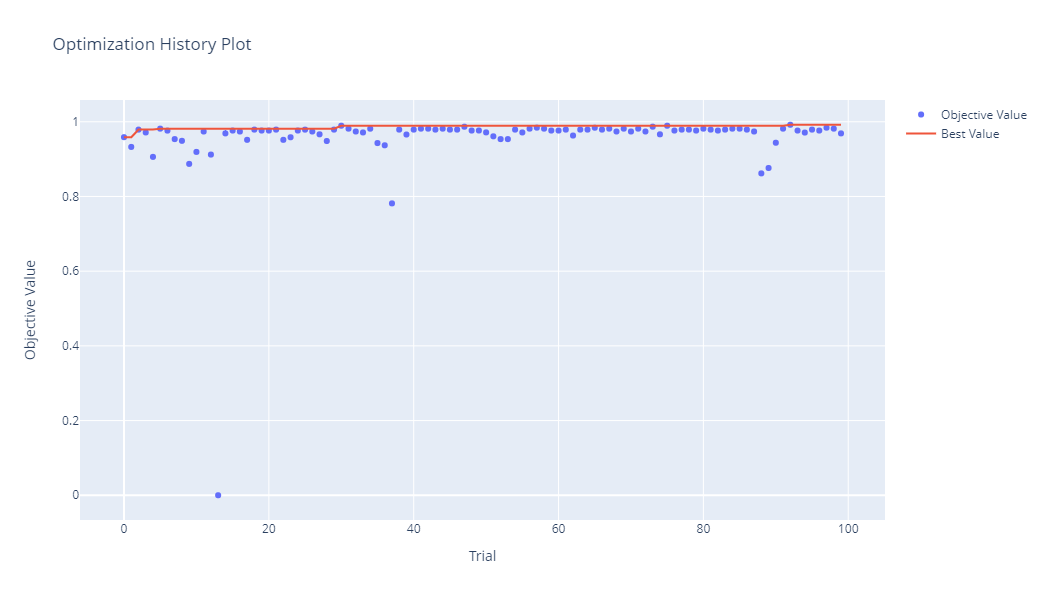

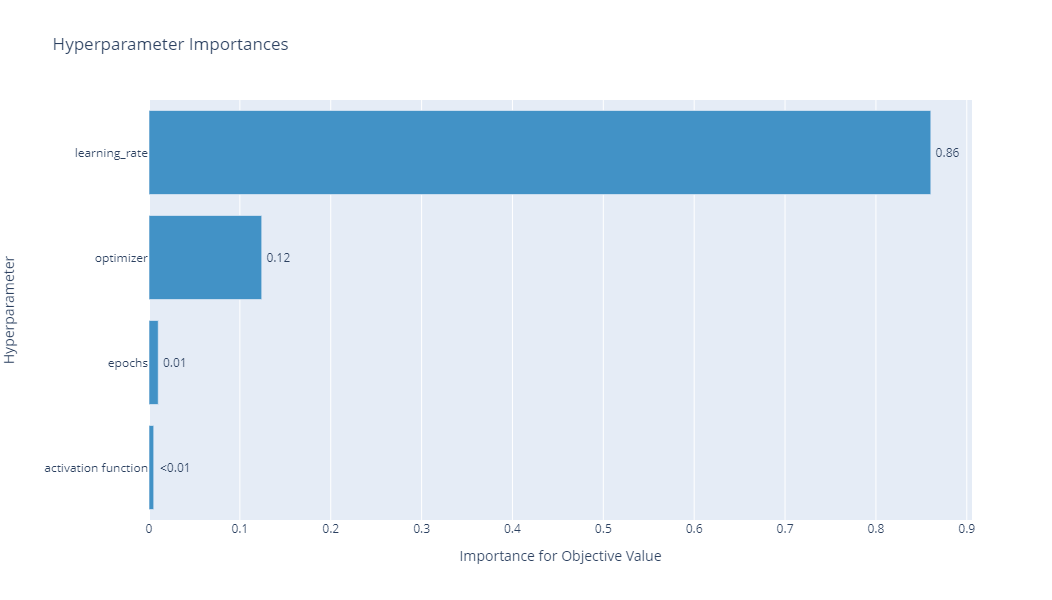

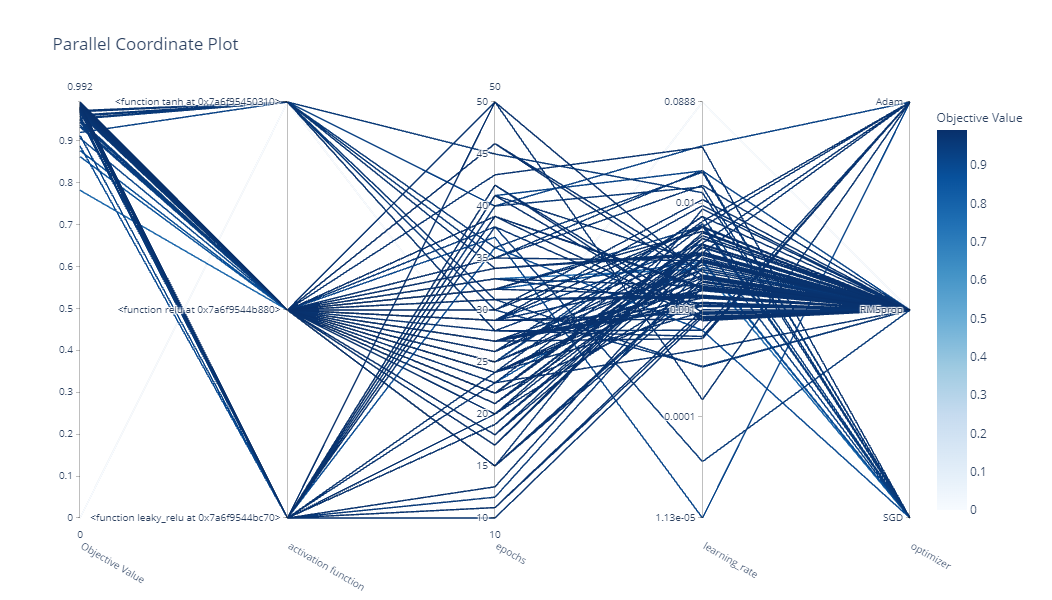

In [47]:
show_study_summary(mlp_study)